In [ ]:
import os
import shutil

# there are 12500 images of cats and 12500 of dogs in the dataset
original_dataset_path = "./dataset/dogs_cats"

original_train_path = original_dataset_path + "/train"
original_test_path = original_dataset_path + "/test"

temp_path = original_dataset_path + "/temp"
train_path = temp_path + "/train"
valuation_path = temp_path + "/valuation"
test_path = temp_path + "/test"

try:
    os.mkdir(temp_path) # creatlập e a temp folder to contain small dataset
    os.mkdir(train_path)
    os.mkdir(valuation_path)
    os.mkdir(test_path)
    
    os.mkdir(train_path +  "/cats")
    os.mkdir(train_path +  "/dogs")
    os.mkdir(valuation_path +  "/cats")
    os.mkdir(valuation_path +  "/dogs")
    os.mkdir(test_path +  "/cats")
    os.mkdir(test_path +  "/dogs")
    
except FileExistsError as e:
    print(str(e))
    



In [4]:
# %load show_plot.py
import matplotlib.pyplot as plt

def show_plot(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [2]:
# move 1000 pics of cats to train, 500 to val, and 500 to test
# same thing for dogs

file_names = ['cat.{}.jpg'.format(i) for i in range(2000)]
for i in range(len(file_names)):
    file = file_names[i]
    
    source = os.path.join(original_train_path, file)
    
    if(i<1000):
        dest = os.path.join(train_path + "/cats", file)
    elif i>=1000 and i<1500:
        dest = os.path.join(valuation_path + "/cats", file)
    else:
        dest = os.path.join(test_path + "/cats", file)
    
    shutil.copy(source, dest)
    
file_names = ['dog.{}.jpg'.format(i) for i in range(2000)]
for i in range(len(file_names)):
    file = file_names[i]
    source = os.path.join(original_train_path, file)
    
    if(i<1000):
        dest = os.path.join(train_path + "/dogs", file)
    elif i>=1000 and i<1500:
        dest = os.path.join(valuation_path + "/dogs", file)
    else:
        dest = os.path.join(test_path + "/dogs", file)
    
    shutil.copy(source, dest)
    

In [3]:
print("# train cats ",len(os.listdir(train_path + "/cats")))
print("# validation cats ",len(os.listdir(valuation_path + "/cats")))
print("# test cats ",len(os.listdir(test_path + "/cats")))

print("# train dogs ",len(os.listdir(train_path + "/dogs")))
print("# validation dogs ",len(os.listdir(valuation_path + "/dogs")))
print("# test dogs ",len(os.listdir(test_path + "/dogs")))

# train cats  1000
# validation cats  500
# test cats  500
# train dogs  1000
# validation dogs  500
# test dogs  500


In [5]:
# build a convnet
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
#32 is the number of filters, (3,3) is kernel size
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3))) 
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dropout(0,5)) # we add this with data augmentation method apply
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='relu'))

print(model.summary())

model.compile(loss='binary_crossentropy', optimizer = optimizers.RMSprop(lr=1e-4), metrics=['acc'])


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv

In [12]:
#process data before feed it to the network
#create a generator
from keras.preprocessing.image import ImageDataGenerator
train_gen = ImageDataGenerator(rescale=1.0/255)
test_gen = ImageDataGenerator(rescale=1.0/255)

# for data augmentation method
data_aug_train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 40, #value range (0-180) randomly rotate image
    width_shift_range=0.2, #/randomly translate image either horizontally or vertically
    height_shift_range=0.2,
    shear_range=0.2, #randomly apply shear transformations to the image
    zoom_range=0.2, #randomly zooming inside the image
    horizontal_flip=True, #flip the image horizontally ( assume the image is not horizontal asymmetry)
    fill_mode='nearest' # fill mode to fill newly created pixels
)

train_generator = data_aug_train_gen.flow_from_directory(
    train_path,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_gen.flow_from_directory(
    valuation_path,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)



for data_batch, labels_batch in train_generator:
    print('data batch shape: ', data_batch.shape)
    print('labels batch shape: ', labels_batch.shape)    
    break

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
data batch shape:  (20, 150, 150, 3)
labels batch shape:  (20,)


In [10]:
model.load_weights('dogs_vs_cats.h5')


In [13]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

model.save('dogs_vs_cats.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 62s 615ms/step - loss: 0.7623 - acc: 0.5650 - val_loss: 0.6672 - val_acc: 0.5810
Epoch 2/30
100/100 [==============================] - 59s 595ms/step - loss: 0.7002 - acc: 0.5790 - val_loss: 0.6381 - val_acc: 0.6400
Epoch 3/30
100/100 [==============================] - 59s 588ms/step - loss: 0.6796 - acc: 0.6165 - val_loss: 0.6201 - val_acc: 0.6370
Epoch 4/30
100/100 [==============================] - 59s 595ms/step - loss: 0.6601 - acc: 0.6225 - val_loss: 0.6426 - val_acc: 0.6090
Epoch 5/30
100/100 [==============================] - 59s 592ms/step - loss: 0.6584 - acc: 0.6390 - val_loss: 0.7179 - val_acc: 0.5560
Epoch 6/30
100/100 [==============================] - 59s 590ms/step - loss: 0.6391 - acc: 0.6290 - val_loss: 0.5952 - val_acc: 0.6740
Epoch 7/30
100/100 [==============================] - 59s 593ms/step - loss: 0.7024 - acc: 0.6410 - val_loss: 0.7408 - val_acc: 0.6190
Epoch 8

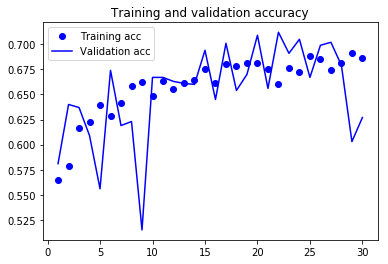

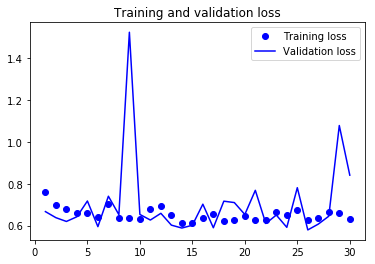

In [15]:
#show plot
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

58892288/58889256 [==============================] - 16s 0us/step


In [18]:
#use a pretrained model VGG16
from keras.applications import VGG16

#feature extraciton without data augmentation
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

#include_top refers to the Dense layer
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

# record output of the conv_base to a numpy array,
# then use that array as an input for the Dense layer

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4,4,512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        batch_size = batch_size,
        target_size=(150,150),
        class_mode='binary',
    )
    
    i=0 # batch index ( a batch contains some number of items such as, in this case, images ) 
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[ i * batch_size : (i+1) * batch_size] = features_batch
        labels[ i * batch_size : (i+1) * batch_size] = labels_batch
        i+=1
        
        # we make sure the conv_base see every image only once.
        if i* batch_size >= sample_count:
            break
        
    return features, labels

train_features, train_labels = extract_features(train_path, 2000)
validation_features, validation_labels = extract_features(valuation_path, 1000)
test_features, test_labels = extract_features(test_path, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
[[[[3.04766327e-01 0.00000000e+00 5.10816038e-01 ... 0.00000000e+00
    3.40505242e-01 0.00000000e+00]
   [3.02747309e-01 0.00000000e+00 8.53787303e-01 ... 4.63060200e-01
    4.91301090e-01 0.00000000e+00]
   [4.91295636e-01 0.00000000e+00 5.90099454e-01 ... 2.00050890e-01
    2.24810779e-01 0.00000000e+00]
   [1.45378113e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    9.12144184e-02 0.00000000e+00]]

  [[1.04055643e+00 0.00000000e+00 6.65114641e-01 ... 0.00000000e+00
    3.98937762e-01 0.00000000e+00]
   [4.29123878e-01 0.00000000e+00 1.16189408e+00 ... 9.23651218e-01
    3.69454354e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 1.01724803e+00 ... 5.81979156e-01
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 1.76862121e-01 ... 0.00000000e+00
    1.16619170e-01 2.21752152e-02]]

  [[1.44103587e+00 0.00000000e+00 1.34529352e+

In [21]:
from keras import models
from keras import layers
from keras import optimizers

#flatten the train features to (4*4*512) to feed to Dense layer
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

# feed the flattened features to the Dense layer
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                   epochs=30, batch_size=20, 
                    validation_data=(validation_features, validation_labels))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 821us/step - loss: 0.6157 - acc: 0.6610 - val_loss: 0.4338 - val_acc: 0.8400
Epoch 2/30
2000/2000 [==============================] - 1s 594us/step - loss: 0.4355 - acc: 0.7985 - val_loss: 0.3608 - val_acc: 0.8600
Epoch 3/30
2000/2000 [==============================] - 1s 607us/step - loss: 0.3538 - acc: 0.8455 - val_loss: 0.3229 - val_acc: 0.8730
Epoch 4/30
2000/2000 [==============================] - 1s 619us/step - loss: 0.3146 - acc: 0.8690 - val_loss: 0.3033 - val_acc: 0.8800
Epoch 5/30
2000/2000 [==============================] - 1s 651us/step - loss: 0.2898 - acc: 0.8760 - val_loss: 0.3016 - val_acc: 0.8680
Epoch 6/30
2000/2000 [==============================] - 2s 764us/step - loss: 0.2646 - acc: 0.8985 - val_loss

In [5]:
show_plot(history)

NameError: name 'history' is not defined

In [10]:
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import models
from keras import layers


conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

test_gen = ImageDataGenerator(rescale=1./255)
data_aug_train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 40, #value range (0-180) randomly rotate image
    width_shift_range=0.2, #/randomly translate image either horizontally or vertically
    height_shift_range=0.2,
    shear_range=0.2, #randomly apply shear transformations to the image
    zoom_range=0.2, #randomly zooming inside the image
    horizontal_flip=True, #flip the image horizontally ( assume the image is not horizontal asymmetry)
    fill_mode='nearest' # fill mode to fill newly created pixels
)

train_generator = data_aug_train_gen.flow_from_directory(
    train_path,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_gen.flow_from_directory(
    valuation_path,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable=False
set_trainable = False

for layer in conv_base.layers:
    if layer.name=='block5_conv1':
        layer.trainable= True

model.compile( loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-5), 
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data = validation_generator,
    validation_steps = 50
)

show_plot(history)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
  4/100 [>.............................] - ETA: 3:53 - loss: 0.6912 - acc: 0.5500

KeyboardInterrupt: 